In [1]:
import numpy as np
import torch
from pathlib import Path
import os
from bnn_priors.models import make_dense
import matplotlib.pyplot as plt

from pyro.infer.mcmc import NUTS, HMC
from pyro.infer.mcmc.api import MCMC

%load_ext autoreload
%autoreload 2

In [2]:
data = np.load("../data/snelson.npz")

model = make_dense(1, 1, 32)

x_train = torch.from_numpy(data['x_train']).unsqueeze(1).to(model.lin1.weight)
y_train = torch.from_numpy(data['y_train']).unsqueeze(1).to(x_train)

x_test = torch.from_numpy(data['x_test']).unsqueeze(1).to(x_train)

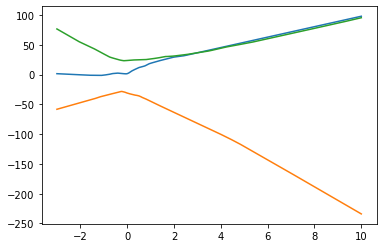

In [3]:
with torch.no_grad():
    # model.sample_all_priors()
    y = model(x_test)
    plt.plot(x_test, y)

    # model.sample_all_priors()
    y = model(x_test)
    plt.plot(x_test, y)

    # model.sample_all_priors()
    y = model(x_test)
    plt.plot(x_test, y)

    plt.show()

In [4]:
N_steps = 20 # 100
warmup = 10 # 50

kernel = NUTS(model=model, adapt_step_size=True, step_size=0.1)
mcmc = MCMC(kernel, num_samples=N_steps, warmup_steps=warmup)
mcmc.run(x=x_train, y=y_train)

samples = mcmc.get_samples()

Sample: 100%|██████████| 30/30 [01:18,  2.62s/it, step size=4.29e-04, acc. prob=0.949]


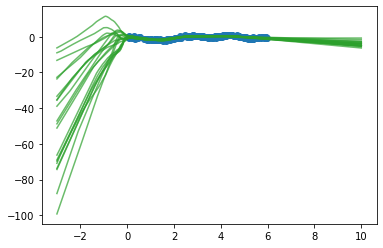

In [5]:
for i in range(N_steps):
    for k in samples.keys():
        path = k.split('.')
        setattr(getattr(model, path[0]), path[1], samples[k][i])
    with torch.no_grad():
        plt.plot(x_test, model(x_test), color="C2", alpha=0.7)
plt.scatter(x_train, y_train)
plt.show()